In [2]:
import pandas as pd
import polars as pl
import duckdb as db
import numpy as np
import scipy.stats as st

from ucimlrepo import fetch_ucirepo 
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_predict, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC
from sklearn.metrics import adjusted_rand_score, silhouette_score, normalized_mutual_info_score, rand_score, adjusted_mutual_info_score, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, mean_squared_error, mean_absolute_error
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from scipy.spatial.distance import pdist, squareform

import os
import xml.etree.ElementTree as ET
from tqdm import tqdm

import time
import matplotlib.pyplot as plt
import seaborn as sns

from urllib.request import urlopen
import xmltodict

from itertools import combinations
from collections import Counter


# HW2

Overall rules:

- Do not split your answers into separate files. All answers must be in a single jupyter notebook. 
- Refrain from downloading and loading data from a local file unless specifically specified. Obtain all required remote data using the appropriate API.
- Refrain from cleaning data by hand on a spreadsheet. All cleaning must be done programmatically, with each step explained. This is so that I can replicate the procedure deterministically.
- Refrain from using code comments to explain what has been done. Document your steps by writing appropriate markdown cells in your notebook.
- Avoid duplicating code by copying and pasting it from one cell to another. If copying and pasting is necessary, develop a suitable function for the task at hand and call that function.
- When providing parameters to a function, never use global variables. Instead, always pass parameters explicitly and always make use of local variables.
- Document your use of LLM models (ChatGPT, Claude, Code Pilot etc). Either take screenshots of your steps and include them with this notebook, or give me a full log (both questions and answers) in a markdown file named HW2-LLM-LOG.md.

Failure to adhere to these guidelines will result in a 15-point deduction for each infraction.

## Atabey's Notes

- Q1: The analysis part looks ok. However, I can't see where you record the time. Did you do it by hand? Also, there is an issue of "confidence intervals". The values you calculate are single. Are you sure about their accuracy? 80
- Q2: Looks good. But you should get the full picture: accuracy, recall, precision, and F1-score. 100
- Q3: Very good. It would been nicer if you also plotted chi-square results over the years. 100
- Q4: You are repeating code here. You didn't have to pull the data for everytime you did an analysis. Lazy. Otherwise looks good. 80

Overall: 90

## Q1

For this question we are going to use [RT-IoT2022](https://archive.ics.uci.edu/dataset/942/rt-iot2022) dataset from [UCI](https://archive.ics.uci.edu/). We have seen several clustering algorithms, and also some measures of quality for clusters in the lectures. Use all you have learned and compare the clustering algorithms we have learnt using the quality measures we have seen in the class.  You must write a detailed comparison analysis to evaluate which model behaves better based on the results you will obtain. One part of your analysis should also include how much time it takes to train and run the models.

In [2]:
rt_iot2022 = fetch_ucirepo(id=942) 
  
X = rt_iot2022.data.features 
y = rt_iot2022.data.targets 

features_encoded = pd.get_dummies(X)

X_all = features_encoded
y_all = y.squeeze()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_all)

In [3]:
def degerlendirme(labels, y_all, X_scaled):
    ri = rand_score(y_all, labels)
    silhouette = silhouette_score(X_scaled, labels)
    mi = adjusted_mutual_info_score(y_all, labels)

    print(f"Rand Index: {ri:.4f}")
    print(f"Silhouette Score: {silhouette:.4f}")
    print(f"Mutual Information: {mi:.4f}")
    

In [4]:
kmeans = KMeans(n_clusters=len(y_all.unique()), random_state=42)
labels_km = kmeans.fit_predict(X_scaled)

print("KMeans")
degerlendirme(labels_km, y_all, X_scaled)

KMeans
Rand Index: 0.7037
Silhouette Score: 0.4400
Mutual Information: 0.5417


In [5]:
agg = AgglomerativeClustering(n_clusters=len(y_all.unique()), linkage='single')
labels_hier = agg.fit_predict(X_scaled)

print("Hierarchical")
degerlendirme(labels_hier, y_all, X_scaled)

Hierarchical
Rand Index: 0.6019
Silhouette Score: 0.9686
Mutual Information: 0.0009


In [7]:
dbscan = DBSCAN(eps=1.5, min_samples=6)
labels_db = dbscan.fit_predict(X_scaled)

print("DBScan")
degerlendirme(labels_db, y_all, X_scaled)

DBScan
Rand Index: 0.6801
Silhouette Score: 0.6391
Mutual Information: 0.6499


Bu veri seti bir makine öğrenmesi uygulaması setidir ve içeriğinde ağ saldırıları vardır. Veri setinde ağ trafiği ile ilgili bilgiler vardır ve target sütununda yani Attack_Type sütununda ise bu trafik sonucunda gerçekleşen eylemin normal bir eylem mi olduğu yoksa bir saldırı mı olduğu, eğer saldırı ise hangi tür olduğuna dair bilgiler vardır. 

Soruda bizden derste görülen kümeleme algoritmalarının kullanılması isteniyor. Bu algoritmalar KMeans, Hierarchical ve DBSCAN algoritmalarıdır. 
KMeans algoritması verileri belirli sayıda kümelere ayırır ve her kümenin merkezini bulur. Daha sonrasında ise diğer veri noktaları kendisine en yakın olan merkez noktasına göre kümelenir. 
Hierarchical algoritmasında veriler hep birlikte bir kümeden başlar ve daha sonrasında özelliklerine göre farklı kümelere ayrılırlar ya da birleştirilirler.
DBSCAN algoritmasında ise veri noktalarının yoğun olduğu bölgeler küme olarak tanımlanır. 

Veri setimizde bu algoritmaları kullanarak çalıştığımızda ise yukarıdaki gibi sonuçlar elde ettik. 
 Soruda istendiği gibi derste öğrenilen ölçüm yöntemleri olan Rand Index, Silhouette Score ve Mutual Information yöntemlerini kullandım.
Bu yöntemlerden Rand Index bizim yaptığımız tahminlere göre oluşturulan kümelerin, gerçek değerlerle karşılaştırarak ne kadar doğru tahmin ettiğimizi ölçer.
Silhouette Score yöntemi bir kümedeki veri noktasının, aynı kümedeki diğer veri noktalarıyla ne kadar benzer özelliklerde olduğunu ölçer ve bunun sonucunu verir.
Mutual Information yöntemi ise bizim yaptığımız tahminlere göre oluşturulan kümelerin, gerçek değerlerle ne kadar uyumlu olduğunu gösterir.

Algoritmalarımızın doğruluk değerleri aşağıdaki gibidir:

| Performans                | KMeans       |Hierarchical |DBSCAN|
|---------------------------|--------------|-------------|------|
| Rand Index                | 0.7037       |0.6019       |0.6801|
| Silhouette Score          | 0.4400       |0.9686       |0.6391|
| Mutual Information        | 0.5417       |0.0009       |0.6499|

Algoritmalar neredeyse benzer sonuçlar verdi ancak Hierarchical metodunun Mutual Information ölçümünün çok düşük çıkması bu metodu kullanmamamıza sebep oldu. Bu metodun Silhouette Score'unun çok iyi olması yani aynı kümedeki veri noktalarının birbirine çok benzer olması bu metodu öne çıkarırken diğer ölçüm yönteminin kötü sonuç vermesi bu metodu elememize sebep oldu. Diğer iki algoritma karşılaştırıldığında ise DBSCAN algoritması daha iyi sonuçlar verdi. Bu yüzden tercih sebebi olabilir ancak tercih edeceğimiz algoritmanın çalışma sürelerini de dikkate almamız bizim için daha faydalı olur. Algoritmaların çalışma süreleri ise aşağıdaki gibidir.

| Algoritma             | Süre   |
|-----------------------|------  |
| KMeans                | 3 dakika 40 saniye|
| Hierarchical          | 21 dakika 8 saniye|
| DBSCAN                | 45 dakika 17 saniye|

Bu tabloya göre KMeans ile DBSCAN arasında yaklaşık 15 katlık bir fark bulunmakta ve KMeans daha hızlı çalışmaktadır. Burada önemli olan zamanın mı yoksa performansın mı bizim için daha önemli olduğudur. 

Süreler arasında ciddi farklar olmasından dolayı ben KMeans algoritmasını kullanmayı tercih ettim. 


## Q2

For this question we are going to use MNIST digits dataset. We have analyzed 3 classification algorithms so far. These are

1. K-NN
2. SVM
3. Logistric Regression

Use these algorithms to obtain 3 classification models on the dataset. Then use an appropriate cross-validation scheme to test the quality of the models and compare. You must write a detailed comparison analysis to evaluate which model behaves better based on the results you will obtain. One part of your analysis should also include how much time it takes to train and run the models.

⏱ K-NN için zaman ölçümü başlatıldı...



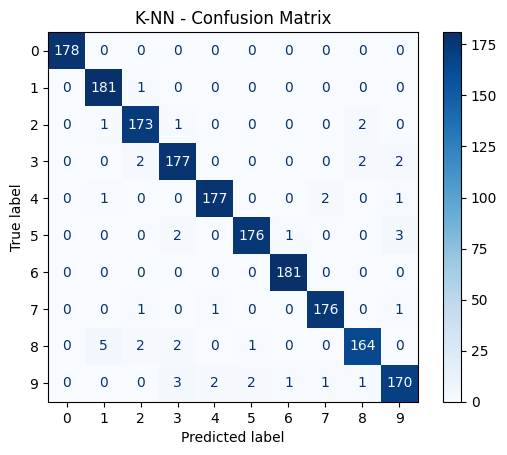

⏱ SVM için zaman ölçümü başlatıldı...



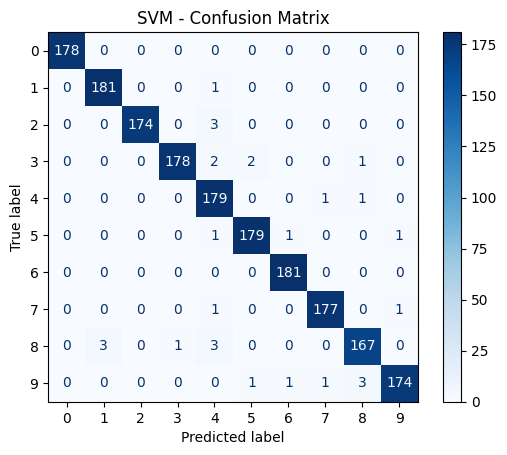

⏱ Logistic Regression için zaman ölçümü başlatıldı...



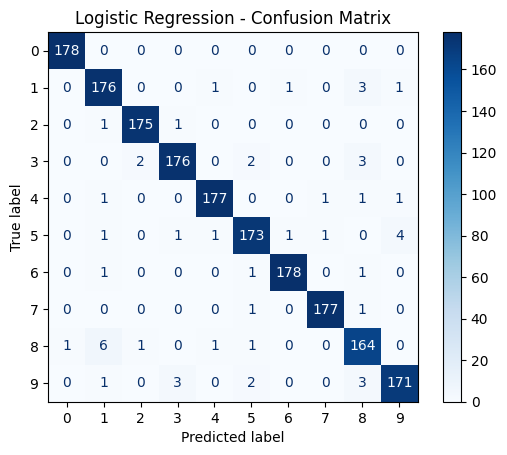

📊 Genel Performans ve Zaman Metrikleri:
                     Accuracy  Precision (macro)  Recall (macro)  \
K-NN                   0.9755             0.9756          0.9754   
SVM                    0.9839             0.9841          0.9838   
Logistic Regression    0.9711             0.9711          0.9711   

                     F1-score (macro)  F1-score (micro)  Time (s)  
K-NN                           0.9754            0.9755    2.3367  
SVM                            0.9839            0.9839    0.2663  
Logistic Regression            0.9711            0.9711    0.1038  


In [9]:
digits = load_digits()
X = digits.data
y = digits.target

models = {
    "K-NN": make_pipeline(StandardScaler(), KNeighborsClassifier(n_neighbors=3)),
    "SVM": make_pipeline(StandardScaler(), SVC(kernel='rbf', gamma='scale')),
    "Logistic Regression": make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000, solver='lbfgs', multi_class='multinomial'))
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = {}

for name, model in models.items():
    print(f"⏱ {name} için zaman ölçümü başlatıldı...\n")
    
    start_time = time.time()
    y_pred = cross_val_predict(model, X, y, cv=cv, n_jobs=-1)
    end_time = time.time()
    
    elapsed_time = end_time - start_time

    acc = accuracy_score(y, y_pred)
    prec = precision_score(y, y_pred, average='macro')
    rec = recall_score(y, y_pred, average='macro')
    f1_macro = f1_score(y, y_pred, average='macro')
    f1_micro = f1_score(y, y_pred, average='micro')
    
    cm = confusion_matrix(y, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f"{name} - Confusion Matrix")
    plt.show()
    
    results[name] = {
        "Accuracy": acc,
        "Precision (macro)": prec,
        "Recall (macro)": rec,
        "F1-score (macro)": f1_macro,
        "F1-score (micro)": f1_micro,
        "Time (s)": elapsed_time
    }

df_results = pd.DataFrame(results).T
print("📊 Genel Performans ve Zaman Metrikleri:")
print(df_results.round(4))


MNIST basamak seti makine öğrenimi ve görüntü işleme alanlarında kullanılan bir veri setidir. Bu veri seti daha çok antrenman yapmak amacıyla kullanılır. Görece daha basit bir veri setidir. 
Algoritmalarımızda ise K-NN yöntemi en yakın komşusuna bakarak bir veri noktasını kümelemeye ve sınıflandırmaya çalışır. Sınıflandırılacak verimiz en çok uyuştuğu diğer noktalarla aynı kümeye konularak sınıflandırılır. K değerimiz en yakın kaç komşuya bakılacağını belirtir.
SVM yöntemi ise farklı sınıflardaki örnekler arasındaki mesafeyi maksimize eder ve bu mesafe arasında bir karar noktası bulur. Daha sonrasında ise bu noktaya göre sınıfları tanımlar. 
Lojistik regresyon yönteminde ise diğer bilgilerden yola çıkarak bir veri noktasının hangi sınıfta olduğu tahmin edilir ve buna göre veri noktaları sınıflara ayrılır. 

Veri setimizde bu yöntemleri kullanarak çalıştığımızda ise yukarıdaki gibi sonuçlar elde ettik. 
Modellerimiz arasından en başarılı tahmin oranına ulaşan model SVM modeli oldu. SVM modeli diğer modellere göre Accuracy metriğinde yani yapılan doğru tahminlerin tüm tahminlere oranında, Precision metriğinde yani modelin bir sınıfa koyduğu verilere ne kadar güvenebileceğimizi belirleyen metrikte, Recall metriğinde yani modelin gerçek değerin ne kadarını doğru olarak tahmin ettiğini gösteren metrikte, F1-Score metriğinde yani Precision ile Recall değerlerinden yola çıkarak bir hesaplama yapan metrikte öndedir. Bütün metriklerde 1 değerine yakın olma durumu daha iyi performans anlamına gelir. Confusion Matrix'te de çakışan(Örn. satırda 1, sütunda 1) hücre sayısı modelimizin bize başarısını gösterir. Burada da SVM rakiplerine göre daha yüksek bir çakışma oranı elde etmiştir.
Bu durum bize SVM modelinin diğer modellere göre daha iyi sonuçlar verdiğini gösterir.

Ancak durumu bir de zaman bakımından ele almak gerekir. Bizim veri setimiz görece basit bir set olduğu için çok kısa sürelerde sonuç alabiliyoruz. Daha karışık ve büyük veri setine denk geldiğimizde ise süre bizim açımızdan önemli hale gelebilir. Modellerin sürelerine baktığımızda K-NN modeli 2.33 saniyede, SVM modeli 0.24 saniyede, Lojistik Regresyon modeli ise 0.11 saniyede çalışmıştır. 

Bu veri seti üzerinde SVM ile K-NN karşılaştırdığımızda SVM hem performans olarak hem de süre olarak daha uyumlu bir modeldir. SVM ile Lojistik Regresyon'u karşılaştırdığımızda ise aralarında yaklaşık 2 katlık bir zaman farkı vardır. SVM daha iyi performans vermesine rağmen daha yavaş çalışmıştır. Burada önemli olan zamanın mı yoksa performansın mı bizim için daha önemli olduğudur. 

Süreler çok kısa olduğu için ben SVM modelini kullanmayı tercih etiim.

## Q3

For this homework, we are going to use the [data warehouse](https://clerk.house.gov/Votes/) for the [US House of Representatives](https://www.house.gov/). The data server has data on each vote going back to 1990. The voting information is in XML format. For example, the code below pulls the data for the 71st roll call from 2024 Congress.

1. Obtain all of the data from 2010 to 2024 (inclusive, all years, all calls). You may save a local copy, and push the local copy onto your github repo.
2. Construct a similarity measure function for a pair of legislators. The function should return the number of times both legislators voted the same way and the number of sessions both attended.
3. Find the legislators whose voting records are the most similar to: (i) Matt Gaetz and (ii) Alexandria Ocasio-Cortez.
4. Using this similarity measure, do a hiearchical clustering for legislators, and analyze the result.
5. Construct a function that takes a year as an input and returns a 2x2 table couting the number of times Democrats voted with other Democrats, the number of times Democrats voted with Republicans, the number of times Republicans voted with Democrats, and the number of times Republicans voted with other Republicans in that year.
6. Analyze the table for each year since 2010 using the $\chi^2$-statistic, and evaluate the polarization in the House of representatives. In this context, explain what a lower or higher $\chi^2$-metric means. Explain whether the polarization in the House of representatives increased or decreased over the years?

In [ ]:
def get_voting_data(year, roll_call):
    url = f'https://clerk.house.gov/evs/{year}/roll{roll_call:03}.xml'
    try:
        with urlopen(url) as response:
            raw = xmltodict.parse(response.read())
            return raw
    except Exception as e:
        print(f"Hata: {url} adresinden veri alınamadı. Hata mesajı: {e}")
        return None

def save_data_to_file(data, year, roll_call):
    if data:
        filename = f'data/{year}/roll{roll_call:03}.xml'
        os.makedirs(os.path.dirname(filename), exist_ok=True)
        with open(filename, 'w', encoding='utf-8') as f:
            f.write(xmltodict.unparse(data, pretty=True))
        print(f"{filename} dosyasına kaydedildi.")

years = range(2010, 2025)
for year in years:
    roll_call = 1
    while True:
        data = get_voting_data(year, roll_call)
        if data is None:
            break
        save_data_to_file(data, year, roll_call)
        roll_call += 1

print("Veri toplama ve kaydetme işlemi tamamlandı.")

In [51]:
def parse_vote_xml(file_path):
    try:
        tree = ET.parse(file_path)
        root = tree.getroot()

        metadata = root.find("vote-metadata")
        rollcall_num = metadata.find("rollcall-num").text
        vote_question = metadata.find("vote-question").text
        vote_result = metadata.find("vote-result").text
        vote_date = metadata.find("action-date").text
        vote_time = metadata.find("action-time").text
        vote_type = metadata.find("vote-type").text
        vote_desc = metadata.find("vote-desc").text

        vote_data = []
        for vote in root.find("vote-data").findall("recorded-vote"):
            legislator = vote.find("legislator")
            vote_choice = vote.find("vote").text

            vote_data.append({
                "id": legislator.attrib.get("name-id"),
                "name": legislator.text,
                "party": legislator.attrib.get("party"),
                "state": legislator.attrib.get("state"),
                "vote": vote_choice,
                "rollcall": rollcall_num,
                "vote_date": vote_date,
            })

        return vote_data
    except Exception as e:
        print(f"Error parsing {file_path}: {e}")
        return []

base_dir = r"C:\Class\MYZ309E\HW2\data"

all_xml_files = []
for year_folder in os.listdir(base_dir):
    year_path = os.path.join(base_dir, year_folder)
    if os.path.isdir(year_path):
        for file in os.listdir(year_path):
            if file.endswith(".xml"):
                all_xml_files.append(os.path.join(year_path, file))

all_votes = []
for xml_file in tqdm(all_xml_files, desc="XML Dosyaları İşleniyor"):
    vote_records = parse_vote_xml(xml_file)
    all_votes.extend(vote_records)

df_all_votes = pd.DataFrame(all_votes)

df_all_votes


XML Dosyaları İşleniyor: 100%|██████████| 9207/9207 [00:43<00:00, 211.14it/s]


,id,name,party,state,vote,rollcall,vote_date
0,A000014,Abercrombie,D,HI,Not Voting,1,12-Jan-2010
1,A000022,Ackerman,D,NY,Present,1,12-Jan-2010
2,A000055,Aderholt,R,AL,Not Voting,1,12-Jan-2010
3,A000364,Adler (NJ),D,NJ,Present,1,12-Jan-2010
4,A000358,Akin,R,MO,Not Voting,1,12-Jan-2010
...,...,...,...,...,...,...,...
3977312,W000795,Wilson (SC),R,SC,Yea,517,20-Dec-2024
3977313,W000804,Wittman,R,VA,Yea,517,20-Dec-2024
3977314,W000809,Womack,R,AR,Yea,517,20-Dec-2024
3977315,Y000067,Yakym,R,IN,Yea,517,20-Dec-2024


In [52]:
valid_votes = ['Yea', 'Aye', 'Nay', 'No']
df_filtered_votes = df_all_votes[df_all_votes["vote"].isin(valid_votes)]

valid_party= ['D', 'R']
df_filtered_votes = df_filtered_votes[df_filtered_votes["party"].isin(valid_party)]

name_mapping = (
    df_filtered_votes.groupby("id")["name"]
    .agg(lambda x: x.value_counts().idxmax())
    .to_dict()
)
df_filtered_votes["name"] = df_filtered_votes["id"].map(name_mapping)

df_filtered_votes["year"] = df_filtered_votes["vote_date"].apply(lambda x: x.split("-")[2])
df_filtered_votes["year_rollcall"] = df_filtered_votes["year"] + "_" + df_filtered_votes["rollcall"].astype(str)

vote_matrix = df_filtered_votes.pivot_table(
    index="year_rollcall", columns="id", values="vote", aggfunc="first"
)


In [53]:
def similarity(legislator_id1, legislator_id2):
    v1 = vote_matrix[legislator_id1]
    v2 = vote_matrix[legislator_id2]

    mask = v1.notna() & v2.notna()
    common_sessions_count = mask.sum()

    same_votes_count = (v1[mask] == v2[mask]).sum()

    return same_votes_count, common_sessions_count

def similarity_ratio(legislator_id1, legislator_id2):
    same, total = similarity(legislator_id1, legislator_id2)
    return same / total if total > 0 else None

def similarity_score(id1, id2):
    v1 = vote_matrix[id1]
    v2 = vote_matrix[id2]
    mask = v1.notna() & v2.notna()
    total = mask.sum()
    same = (v1[mask] == v2[mask]).sum()
    return same / total if total > 0 else 0

def find_most_similar(target_id, top_n=5):
    scores = []
    for other_id in vote_matrix.columns:
        if other_id != target_id:
            score = similarity_score(target_id, other_id)
            scores.append((other_id, score))
    sorted_scores = sorted(scores, key=lambda x: x[1], reverse=True)
    return sorted_scores[:top_n]

similarity("I000023", "A000055")

(np.int64(542), np.int64(569))

In [54]:
similarity_ratio("I000023", "A000055")

np.float64(0.9525483304042179)

In [55]:
gaetz_id = df_filtered_votes[df_filtered_votes["name"].str.contains("Gaetz", case=False, na=False)]["id"].unique()
aoc_id = df_filtered_votes[df_filtered_votes["name"].str.contains("Ocasio", case=False, na=False)]["id"].unique()

print("Matt Gaetz ID:", gaetz_id)
print("AOC ID:", aoc_id)
id_to_name = df_filtered_votes.set_index("id")["name"].to_dict()

gaetz_top_matches = find_most_similar(gaetz_id[0])
print("\nMatt Gaetz'e en çok benzeyenler:")
for uid, score in gaetz_top_matches:
    print(f"{id_to_name.get(uid, 'Bilinmeyen')} ({uid}): {score:.2%}")

aoc_top_matches = find_most_similar(aoc_id[0])
print("\nAlexandria Ocasio-Cortez'e en çok benzeyenler:")
for uid, score in aoc_top_matches:
    print(f"{id_to_name.get(uid, 'Bilinmeyen')} ({uid}): {score:.2%}")



Matt Gaetz ID: ['G000578']
AOC ID: ['O000172']

Matt Gaetz'e en çok benzeyenler:
Mulvaney (M001182): 100.00%
Price (GA) (P000591): 100.00%
Chaffetz (C001076): 94.56%
DeSantis (D000621): 94.28%
Franks (AZ) (F000448): 94.19%

Alexandria Ocasio-Cortez'e en çok benzeyenler:
Lee (PA) (L000602): 99.15%
Ramirez (R000617): 98.96%
Bowman (B001223): 98.69%
Pressley (P000617): 98.48%
Lee Carter (L000605): 98.36%


In [ ]:
def fill_missing_votes_by_party_fast(X, df_filtered_votes):
    from collections import defaultdict

    id_to_party = df_filtered_votes.drop_duplicates("id").set_index("id")["party"].to_dict()

    party_majority_votes = defaultdict(dict)

    for col in X.columns:
        for party in ["D", "R"]:
            party_votes = X.loc[X["party"] == party, col]
            vote_counts = party_votes.value_counts()
            if not vote_counts.empty:
                party_majority_votes[col][party] = vote_counts.idxmax()

    filled_X = X.copy()
    for row_id in filled_X.index:
        party = id_to_party.get(row_id)
        if not party:
            continue
        for col in X.columns:
            if pd.isna(filled_X.at[row_id, col]):
                majority_vote = party_majority_votes.get(col, {}).get(party, None)
                if majority_vote is not None:
                    filled_X.at[row_id, col] = majority_vote

    return filled_X.drop(columns=["party"])


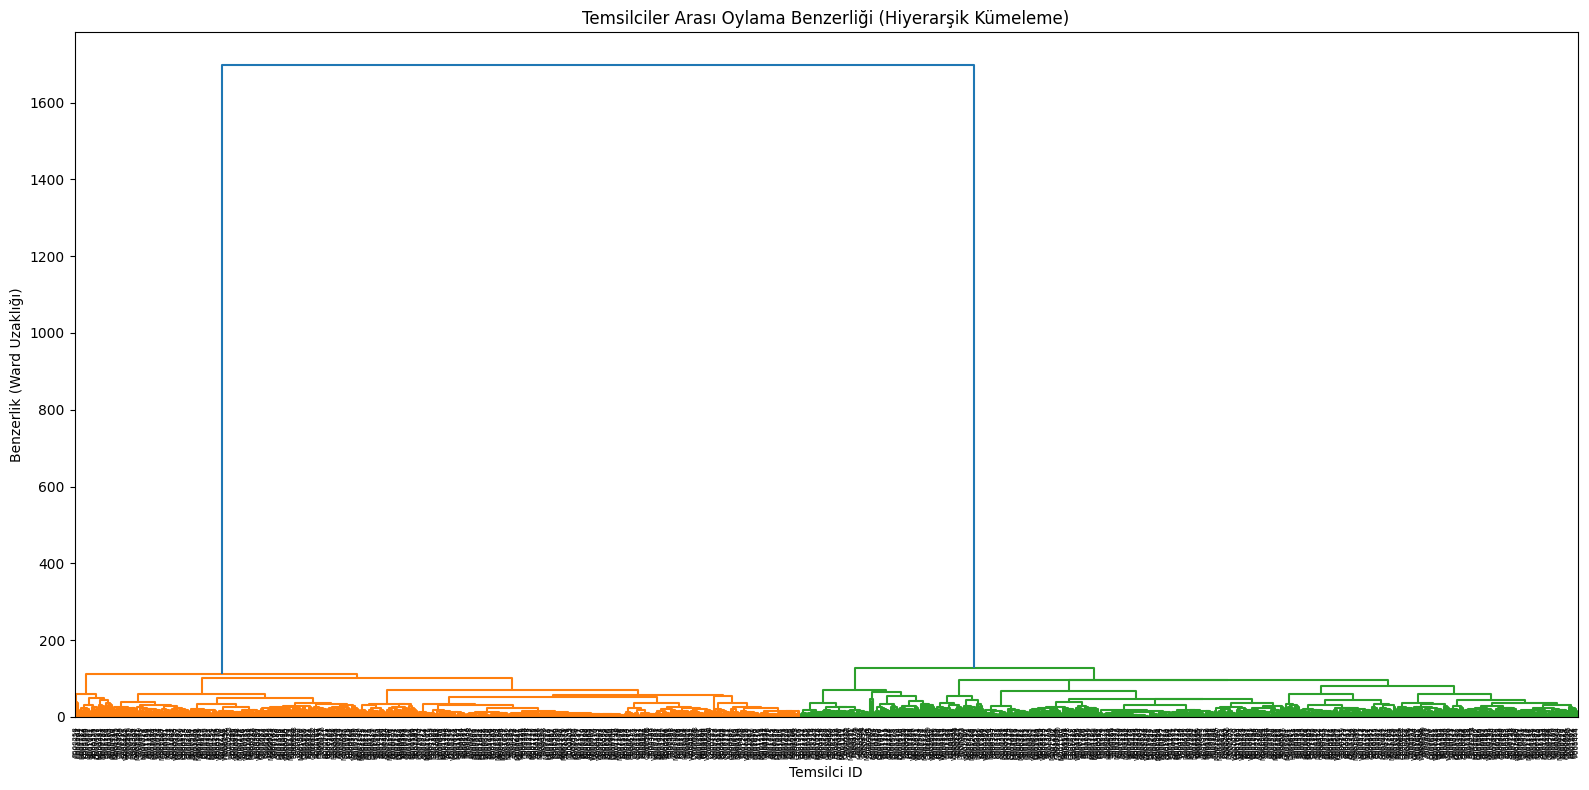

In [ ]:
vote_numeric = vote_matrix.replace({'Yea': 2, 'Aye': 2, 'Nay': 1, 'No': 1})
X = vote_numeric.T
X["party"] = X.index.map(lambda x: id_to_party.get(x))

X_filled = fill_missing_votes_by_party_fast(X, df_filtered_votes)

linkage_matrix = linkage(X_filled, method='ward')

plt.figure(figsize=(16, 8))
dendrogram(linkage_matrix, labels=X_filled.index.to_list(), leaf_rotation=90)
plt.title("Temsilciler Arası Oylama Benzerliği (Hiyerarşik Kümeleme)")
plt.xlabel("Temsilci ID")
plt.ylabel("Benzerlik (Ward Uzaklığı)")
plt.tight_layout()
plt.show()

En temel seviyede milletvekillerini kapsayan büyük bir küme var. Bu küme benzer oy verme verilerine sahip olan milletvekillerini gösteriyor. Milletvekilleri muhtemelen en baştan aynı kümelere dahil oldular ve bu yüzden büyük bir sayıyla aynı kümeye girdiler. Daha sonrasında ise konular özelleşti ve aşağıya doğru inildikçe ise küme sayısı artıyor ve oy verme davranışları özelleşmeye başlıyor.

In [ ]:
def party_agreement_ratio_table(year, df_filtered_votes):
    df_year = df_filtered_votes[df_filtered_votes["year"] == str(year)]

    vote_matrix = df_year.pivot_table(
        index="year_rollcall", columns="id", values="vote", aggfunc="first"
    )

    vote_numeric = vote_matrix.replace({'Yea': 1, 'Aye': 1, 'Nay': 0, 'No': 0})
    vote_numeric = vote_numeric.dropna(how="all", axis=0)

    id_to_party = df_year.drop_duplicates("id").set_index("id")["party"].to_dict()

    agreement_counts = {
        ("D", "D"): [0, 0],
        ("D", "R"): [0, 0],
        ("R", "D"): [0, 0],
        ("R", "R"): [0, 0]
    }

    for _, row in vote_numeric.iterrows():
        valid_votes = row.dropna()
        for id1, vote1 in valid_votes.items():
            party1 = id_to_party.get(id1)
            if party1 not in ["D", "R"]:
                continue
            for id2, vote2 in valid_votes.items():
                party2 = id_to_party.get(id2)
                if party2 not in ["D", "R"] or id1 >= id2:
                    continue
                agreement_counts[(party1, party2)][1] += 1
                agreement_counts[(party2, party1)][1] += 1
                if vote1 == vote2:
                    agreement_counts[(party1, party2)][0] += 1
                    agreement_counts[(party2, party1)][0] += 1

    result_table = pd.DataFrame(
        {
            "Democrat": [
                agreement_counts[("D", "D")][0] / agreement_counts[("D", "D")][1] if agreement_counts[("D", "D")][1] > 0 else 0,
                agreement_counts[("R", "D")][0] / agreement_counts[("R", "D")][1] if agreement_counts[("R", "D")][1] > 0 else 0,
            ],
            "Republican": [
                agreement_counts[("D", "R")][0] / agreement_counts[("D", "R")][1] if agreement_counts[("D", "R")][1] > 0 else 0,
                agreement_counts[("R", "R")][0] / agreement_counts[("R", "R")][1] if agreement_counts[("R", "R")][1] > 0 else 0,
            ]
        },
        index=["Democrat", "Republican"]
    )

    return (result_table * 100).round(2)


In [68]:
party_agreement_ratio_table(2010, df_filtered_votes)


C:\Users\gs_ke\AppData\Local\Temp\ipykernel_7256\3337380425.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  vote_numeric = vote_matrix.replace({'Yea': 1, 'Aye': 1, 'Nay': 0, 'No': 0})


,Democrat,Republican
Democrat,93.71,61.53
Republican,61.53,92.98


In [70]:
party_agreement_ratio_table(2011, df_filtered_votes)

C:\Users\gs_ke\AppData\Local\Temp\ipykernel_7256\3337380425.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  vote_numeric = vote_matrix.replace({'Yea': 1, 'Aye': 1, 'Nay': 0, 'No': 0})


,Democrat,Republican
Democrat,84.7,29.00
Republican,29.0,88.33


In [71]:
party_agreement_ratio_table(2012, df_filtered_votes)

C:\Users\gs_ke\AppData\Local\Temp\ipykernel_7256\3337380425.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  vote_numeric = vote_matrix.replace({'Yea': 1, 'Aye': 1, 'Nay': 0, 'No': 0})


,Democrat,Republican
Democrat,85.89,32.26
Republican,32.26,89.09


In [72]:
party_agreement_ratio_table(2013, df_filtered_votes)

C:\Users\gs_ke\AppData\Local\Temp\ipykernel_7256\3337380425.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  vote_numeric = vote_matrix.replace({'Yea': 1, 'Aye': 1, 'Nay': 0, 'No': 0})


,Democrat,Republican
Democrat,86.84,34.17
Republican,34.17,90.19


In [73]:
party_agreement_ratio_table(2014, df_filtered_votes)

C:\Users\gs_ke\AppData\Local\Temp\ipykernel_7256\3337380425.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  vote_numeric = vote_matrix.replace({'Yea': 1, 'Aye': 1, 'Nay': 0, 'No': 0})


,Democrat,Republican
Democrat,90.00,30.11
Republican,30.11,90.66


In [74]:
party_agreement_ratio_table(2015, df_filtered_votes)

C:\Users\gs_ke\AppData\Local\Temp\ipykernel_7256\3337380425.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  vote_numeric = vote_matrix.replace({'Yea': 1, 'Aye': 1, 'Nay': 0, 'No': 0})


,Democrat,Republican
Democrat,91.64,27.76
Republican,27.76,89.50


In [75]:
party_agreement_ratio_table(2016, df_filtered_votes)

C:\Users\gs_ke\AppData\Local\Temp\ipykernel_7256\3337380425.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  vote_numeric = vote_matrix.replace({'Yea': 1, 'Aye': 1, 'Nay': 0, 'No': 0})


,Democrat,Republican
Democrat,93.39,28.61
Republican,28.61,92.88


In [76]:
party_agreement_ratio_table(2017, df_filtered_votes)

C:\Users\gs_ke\AppData\Local\Temp\ipykernel_7256\3337380425.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  vote_numeric = vote_matrix.replace({'Yea': 1, 'Aye': 1, 'Nay': 0, 'No': 0})


,Democrat,Republican
Democrat,93.35,26.76
Republican,26.76,92.81


In [77]:
party_agreement_ratio_table(2018, df_filtered_votes)

C:\Users\gs_ke\AppData\Local\Temp\ipykernel_7256\3337380425.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  vote_numeric = vote_matrix.replace({'Yea': 1, 'Aye': 1, 'Nay': 0, 'No': 0})


,Democrat,Republican
Democrat,91.93,42.11
Republican,42.11,91.93


In [78]:
party_agreement_ratio_table(2019, df_filtered_votes)

C:\Users\gs_ke\AppData\Local\Temp\ipykernel_7256\3337380425.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  vote_numeric = vote_matrix.replace({'Yea': 1, 'Aye': 1, 'Nay': 0, 'No': 0})


,Democrat,Republican
Democrat,96.64,33.91
Republican,33.91,86.87


In [79]:
party_agreement_ratio_table(2020, df_filtered_votes)

C:\Users\gs_ke\AppData\Local\Temp\ipykernel_7256\3337380425.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  vote_numeric = vote_matrix.replace({'Yea': 1, 'Aye': 1, 'Nay': 0, 'No': 0})


,Democrat,Republican
Democrat,96.16,30.91
Republican,30.91,90.19


In [80]:
party_agreement_ratio_table(2021, df_filtered_votes)

C:\Users\gs_ke\AppData\Local\Temp\ipykernel_7256\3337380425.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  vote_numeric = vote_matrix.replace({'Yea': 1, 'Aye': 1, 'Nay': 0, 'No': 0})


,Democrat,Republican
Democrat,97.82,35.87
Republican,35.87,89.85


In [81]:
party_agreement_ratio_table(2022, df_filtered_votes)

C:\Users\gs_ke\AppData\Local\Temp\ipykernel_7256\3337380425.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  vote_numeric = vote_matrix.replace({'Yea': 1, 'Aye': 1, 'Nay': 0, 'No': 0})


,Democrat,Republican
Democrat,97.79,43.51
Republican,43.51,85.67


In [82]:
party_agreement_ratio_table(2023, df_filtered_votes)

C:\Users\gs_ke\AppData\Local\Temp\ipykernel_7256\3337380425.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  vote_numeric = vote_matrix.replace({'Yea': 1, 'Aye': 1, 'Nay': 0, 'No': 0})


,Democrat,Republican
Democrat,95.13,28.45
Republican,28.45,86.30


In [83]:
party_agreement_ratio_table(2024, df_filtered_votes)

C:\Users\gs_ke\AppData\Local\Temp\ipykernel_7256\3337380425.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  vote_numeric = vote_matrix.replace({'Yea': 1, 'Aye': 1, 'Nay': 0, 'No': 0})


,Democrat,Republican
Democrat,93.07,34.70
Republican,34.70,88.62


Bazı yıllarda verilen aynı oy oranları artış gösterse de genel olarak benzer seviyede reddetmiş. Bu yıllarda ABD politikasında değişiklikler olması bana çok muhtemel geldi. Genellikle ülkelerin güvenlik problemleri olduğunda halk meclisten birlik içinde davranmasını bekliyor veya bir güvenlik tasarısı söz konusu olduğunda vekiller gelen baskılara direnemeyebiliyor. Bu yüzden de benzer oylar kullanıyorlar. Aynı oy kullanmalarının sebepleri bu gibi nedenler olabilir. Bu nedenlerin arasında çevre faaliyetleri, insan hakları problemleri, farklı ülkelere yönelik alınacak tedbirler, iç sorunlar da örnek gösterilebilir. Bu birkaç yıl haricinde ise oranlar %30 seviyelerinde dağılmış yani benzerlik göstermiş. %30 benim beklediğimden yüksek çıktı açıkçası. Ben daha ayrık, daha kutuplu bir meclis bekliyordum. Ama sonuç olarak vekillerin kendi partileri ile oy oranlarına kıyasla karşılaştırdığımızda %30 çok düşük kalıyor. Bu da partilerin birbirlerinin önerilerini dinlememesinden kaynaklanabilir. Diğer sebep olarak da partiler genellikle halk yararına bir öneri geldiğinde çoğunluk olan partinin yaptığı bir şey olarak gözükmesin diye reddedebiliyorlar. Ya da çoğunluk olan parti muhalefetin iyi yaptığı bir şey olarak gözükmesin diye bu öneriyi reddedebiliyor. Bu gibi sebeplerden bu oy oranları çıkmış olabilir. 

In [ ]:
from scipy.stats import chi2_contingency

def chi_squared_stats_per_year(df_filtered_votes, start_year=2010, end_year=2024):
    results = []

    for year in range(start_year, end_year + 1):
        try:
            df_year = df_filtered_votes[df_filtered_votes["year"] == str(year)]

            vote_matrix = df_year.pivot_table(
                index="year_rollcall", columns="id", values="vote", aggfunc="first"
            )
            vote_numeric = vote_matrix.replace({'Yea': 1, 'Aye': 1, 'Nay': 0, 'No': 0})
            vote_numeric = vote_numeric.dropna(how="all", axis=0)

            id_to_party = df_year.drop_duplicates("id").set_index("id")["party"].to_dict()

            agreement_counts = {
                ("D", "D"): 0,
                ("D", "R"): 0,
                ("R", "R"): 0,
            }

            for _, row in vote_numeric.iterrows():
                valid_votes = row.dropna()
                for id1, vote1 in valid_votes.items():
                    party1 = id_to_party.get(id1)
                    if party1 not in ["D", "R"]:
                        continue
                    for id2, vote2 in valid_votes.items():
                        party2 = id_to_party.get(id2)
                        if party2 not in ["D", "R"] or id1 >= id2:
                            continue
                        if vote1 == vote2:
                            key = tuple(sorted([party1, party2]))
                            agreement_counts[key] += 1

            table = [
                [agreement_counts[("D", "D")], agreement_counts[("D", "R")]],
                [agreement_counts[("D", "R")], agreement_counts[("R", "R")]]
            ]

            chi2, p, dof, expected = chi2_contingency(table)

            results.append({
                "year": year,
                "chi2_statistic": chi2,
                "p_value": p,
                "observed_table": table
            })

        except Exception as e:
            print(f"{year} için hata: {e}")
            continue

    return pd.DataFrame(results)


In [85]:
chi2_results = chi_squared_stats_per_year(df_filtered_votes)


C:\Users\gs_ke\AppData\Local\Temp\ipykernel_7256\4154218161.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  vote_numeric = vote_matrix.replace({'Yea': 1, 'Aye': 1, 'Nay': 0, 'No': 0})
C:\Users\gs_ke\AppData\Local\Temp\ipykernel_7256\4154218161.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  vote_numeric = vote_matrix.replace({'Yea': 1, 'Aye': 1, 'Nay': 0, 'No': 0})
C:\Users\gs_ke\AppData\Local\Temp\ipykernel_7256\4154218161.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a fut

In [86]:
chi2_results

,year,chi2_statistic,p_value,observed_table
0,2010,1.074867e+06,0.0,"[[17983149, 16349800], [16349800, 8476036]]"
1,2011,2.209157e+06,0.0,"[[13503412, 11809924], [11809924, 22781274]]"
2,2012,9.027305e+05,0.0,"[[9005623, 8789043], [8789043, 15634592]]"
3,2013,6.897963e+05,0.0,"[[10165567, 9459527], [9459527, 14647523]]"
4,2014,1.394729e+06,0.0,"[[9093340, 7187109], [7187109, 12663029]]"
5,2015,2.462005e+06,0.0,"[[10398116, 8406362], [8406362, 17914494]]"
6,2016,2.156495e+06,0.0,"[[9047469, 7435317], [7435317, 16048368]]"
7,2017,3.170976e+06,0.0,"[[11436106, 8150230], [8150230, 17410341]]"
8,2018,6.137686e+04,0.0,"[[7456396, 8466356], [8466356, 11367914]]"
9,2019,1.038214e+06,0.0,"[[17626951, 10358759], [10358759, 11007678]]"


## Q4

For this question, we are going to use the following dataset.

1. Write a regression model that predicts the Amount from the other variables. Assess the quality of the model using an appropriate measure.
2. Write a logistic regression model that predicts the Class from other variables. Assess the quality of the model using an appropriate measure.
3. The quality of the model seem very good, but in reality it doesn't work. Why? What is the problem? Offer a solution, implement and test it. Did it really solve our problem? Explain.
4. Try other supervised classification models we have learned. Are they susceptible to the same problem as before? Explain. Offer a solution, implement and test it. Did it really solve our problem? Explain.

In [ ]:
url = 'https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv'
credit = pd.read_csv(url)

X_1 = credit.drop(columns=['Amount', 'Class'])
y_1 = credit['Amount']

X_train, X_test, y_train, y_test = train_test_split(X_1, y_1, test_size=0.2, random_state=42)

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
nonzero_mask = y_test != 0
mape = np.mean(np.abs((y_test[nonzero_mask] - y_pred[nonzero_mask]) / y_test[nonzero_mask])) * 100

print("Mean Squared Error (MSE):", mse)
print("RMSE (Root Mean Squared Error):", rmse)
print("MAE (Mean Absolute Error):", mae)
print("MAPE (Mean Absolute Percentage Error):", mape)



Mean Squared Error (MSE): 4333.019546066792
RMSE (Root Mean Squared Error): 65.8256754319072
MAE (Mean Absolute Error): 24.396598398954588
MAPE (Mean Absolute Percentage Error): 1115.1711163548148


c:\Users\gs_ke\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy: 0.9992
Precision: 0.8205
Recall: 0.6531
ROC-AUC: 0.9439


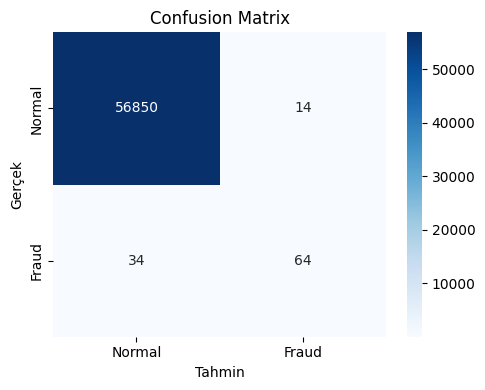

In [ ]:
X_2 = credit.drop(columns=['Class'])
y_2 = credit['Class']              

X_train, X_test, y_train, y_test = train_test_split(X_2, y_2, test_size=0.2, random_state=42, stratify=y_2)

log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

y_pred = log_reg.predict(X_test)
y_pred_proba = log_reg.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {recall:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

plt.figure(figsize=(5,4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Fraud"], yticklabels=["Normal", "Fraud"])
plt.xlabel("Tahmin")
plt.ylabel("Gerçek")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

Bu modelin gerçekte işe yaramamasının sebebi bir sınıftan çok fazla olmasıdır. Veri seti özelliklerinde belirtildiği gibi bu dengesiz bir veri setidir. Normal işlemler çok fazla olduğu için model normal işlemlere doğru bir yönelme gösteriyor. Bu sebepten dolayı da Fraud işlemleri tahmin edemiyor. 

Çözüm yöntemlerine baktığımda ise önüme iki seçenek çıktı. Undersampling yani çoğunluk sınıf olan Normal işlemleri azaltmak veya Oversampling yani azınlık sınıf olan Fraud işlemleri çoğaltmak. Ben burada veri kaybı yaşamamak için Oversampling yöntemini uygulamaya karar verdim.  

c:\Users\gs_ke\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\gs_ke\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


Accuracy: 0.9875
Precision: 0.1111
Recall: 0.8980
ROC-AUC: 0.9761


c:\Users\gs_ke\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


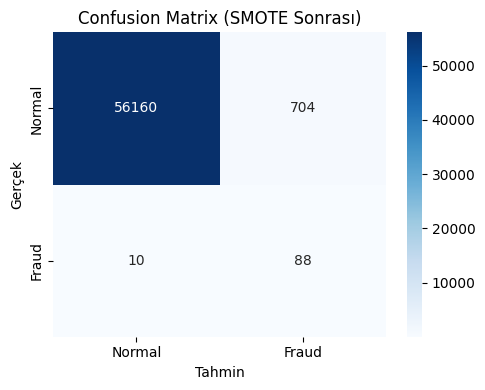

In [ ]:
url = 'https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv'
credit = pd.read_csv(url)

X = credit.drop(columns=['Class'])
y = credit['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

model = LogisticRegression(max_iter=1000)
model.fit(X_train_res, y_train_res)

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {recall:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Fraud"], yticklabels=["Normal", "Fraud"])
plt.xlabel("Tahmin")
plt.ylabel("Gerçek")
plt.title("Confusion Matrix (SMOTE Sonrası)")
plt.tight_layout()
plt.show()


Oversampling uygulamak sonuçları değiştirdi ancak hala tam olarak istediğim seviyede değil. Yine de Fraud'ları sayı olarak doğru tahmin etme oranı iyi bir derecede artmış görünüyor. Ancak bunda şöyle bir yanılgıya da düşebiliriz. Oversampling işlemi yaptıktan sonra Precision metriğimiz oldukça düştü. Confusion Matrix'ten de görebileceğimiz üzere modelin Fraud tahmin sayısı bir hayli arttı ve bunlar yanlış tahminler. Yani model rastgele olarak Fraud tahmini de yapıyor. Bu da istemediğimiz bir durum. Bu yüzden ben bu veri seti ve bu model üzerinde Oversampling yöntemini ne başarılı ne de başarısız buldum. 

c:\Users\gs_ke\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:484: FutureWarning: `BaseEstimator._check_n_features` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_n_features` instead.
  warnings.warn(
c:\Users\gs_ke\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:493: FutureWarning: `BaseEstimator._check_feature_names` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation._check_feature_names` instead.
  warnings.warn(
c:\Users\gs_ke\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mo

Accuracy: 0.9577
Precision: 0.0361
Recall: 0.9184
ROC-AUC: 0.9754


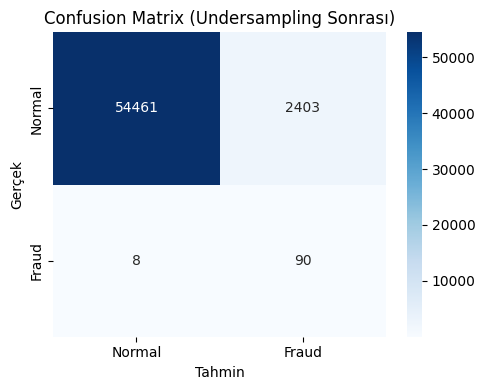

In [ ]:
url = 'https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv'
credit = pd.read_csv(url)

X = credit.drop(columns=['Class'])
y = credit['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

rus = RandomUnderSampler(random_state=42)
X_train_res, y_train_res = rus.fit_resample(X_train, y_train)

model = LogisticRegression(max_iter=1000)
model.fit(X_train_res, y_train_res)

y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall: {recall:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

plt.figure(figsize=(5, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Fraud"], yticklabels=["Normal", "Fraud"])
plt.xlabel("Tahmin")
plt.ylabel("Gerçek")
plt.title("Confusion Matrix (Undersampling Sonrası)")
plt.tight_layout()
plt.show()


Undersampling uygulamak sonuçları neredeyse hiç değiştirmedi. Oversampling yöntemiyle arasında neredeyse fark yok. Hatta Undersampling SMOTE'un yaptığı hataları daha da ileri bir seviyede yaptı.


🔍 Model: Random Forest
Accuracy : 0.9996
Precision: 0.9412
Recall   : 0.8163
ROC-AUC  : 0.9630


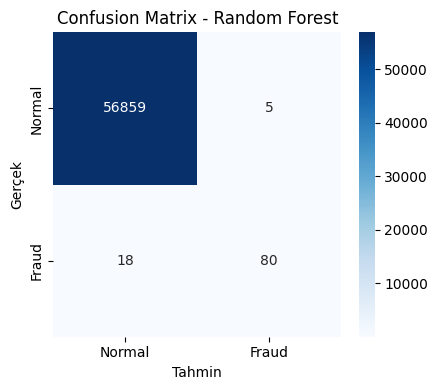


🔍 Model: XGBoost


c:\Users\gs_ke\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\core.py:158: UserWarning: [20:16:39] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy : 0.9995
Precision: 0.9186
Recall   : 0.8061
ROC-AUC  : 0.9743


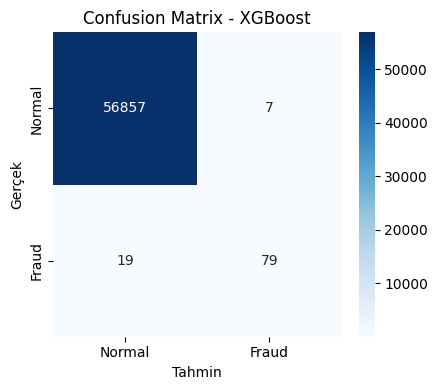


🔍 Model: KNN
Accuracy : 0.9983
Precision: 1.0000
Recall   : 0.0306
ROC-AUC  : 0.6364


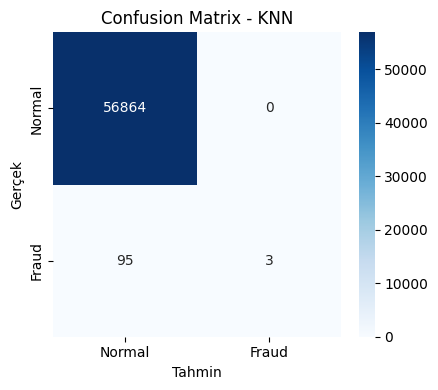


🔍 Model: SVM
Accuracy : 0.9983
Precision: 0.0000
Recall   : 0.0000
ROC-AUC  : 0.4037


c:\Users\gs_ke\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


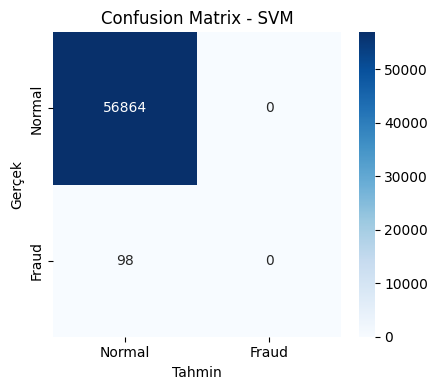

In [ ]:
url = 'https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv'
credit = pd.read_csv(url)

X = credit.drop(columns=['Class'])
y = credit['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "SVM": SVC(probability=True, random_state=42)
}

for name, model in models.items():
    print(f"\n🔍 Model: {name}")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba)
    conf_matrix = confusion_matrix(y_test, y_pred)

    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"ROC-AUC  : {roc_auc:.4f}")

    plt.figure(figsize=(4.5, 4))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Fraud"], yticklabels=["Normal", "Fraud"])
    plt.xlabel("Tahmin")
    plt.ylabel("Gerçek")
    plt.title(f"Confusion Matrix - {name}")
    plt.tight_layout()
    plt.show()

Bu modeller arasında en doğru sonucu Random Forest ve XGBoost modelleri verdi. SVM modeli tamamına Normal işlem, K-NN modeli ise neredeyse tamamına yakınına Normal işlem dedi. Bu yüzden de Precision ve Recall değerleri 0 ve 0'a çok yakın çıktı. Random Forest ile XGBoost ise Regresyon modellerine göre daha iyi sonuçlar verdi. 
Açıkçası Lecture 9'dan Random Forest ve XGBoost modellerini araştırdığımda böyle bir sonuç bekliyordum. Temel mantıkları bu veri setine uyuyor gibi gelmişti bana. Beklediğim gibi de bir sonuç çıktı. Bu iki model tam anlamıyla olmasa da sorunumuzu çözdü diyebiliriz.